In [1]:
import pyspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np

In [2]:
spark = SparkSession.builder.appName("abc").master("spark://spark-master:7077").getOrCreate()

In [3]:
spark

In [5]:
from pyspark.sql.types import StructType,StructField, StringType, DoubleType

schema = StructType([
      StructField("sbd",StringType(),True),
      StructField("toan",DoubleType(),True),
      StructField("ngu_van",DoubleType(),True),
      StructField("ngoai_ngu",DoubleType(),True),
      StructField("vat_li",DoubleType(),True),
      StructField("hoa_hoc",DoubleType(),True),
      StructField("sinh_hoc",DoubleType(),True),
      StructField("lich_su",DoubleType(),True),
      StructField("dia_li",DoubleType(),True),
      StructField("gdcd",DoubleType(),True),
  ])

In [6]:
data_frame = spark.read.schema(schema) \
    .csv("hdfs://namenode:9000/data/*.csv", header=False)
data_frame.printSchema()
data_frame.show()

root
 |-- sbd: string (nullable = true)
 |-- toan: double (nullable = true)
 |-- ngu_van: double (nullable = true)
 |-- ngoai_ngu: double (nullable = true)
 |-- vat_li: double (nullable = true)
 |-- hoa_hoc: double (nullable = true)
 |-- sinh_hoc: double (nullable = true)
 |-- lich_su: double (nullable = true)
 |-- dia_li: double (nullable = true)
 |-- gdcd: double (nullable = true)

+--------+----+-------+---------+------+-------+--------+-------+------+----+
|     sbd|toan|ngu_van|ngoai_ngu|vat_li|hoa_hoc|sinh_hoc|lich_su|dia_li|gdcd|
+--------+----+-------+---------+------+-------+--------+-------+------+----+
|01000001| 3.6|    5.0|      4.0|  null|   null|    null|   2.75|   6.0|8.75|
|01000002| 8.4|   6.75|      7.6|  null|   null|    null|    8.5|   7.5|8.25|
|01000003| 5.8|    7.5|      5.0|  null|   null|    null|   7.25|   5.5|8.75|
|01000004| 7.4|    7.5|      8.6|  null|   null|    null|    7.5|   6.5| 7.5|
|01000005| 7.2|    8.5|      9.0|  null|   null|    null|    8.0|  

In [7]:
data_frame.createOrReplaceTempView("student")

In [9]:
def count_10(subject):
    spark.sql("select count("+ subject +") \
                      from student where (" + subject + " ==10 )").show()

In [44]:
plt.rcParams["figure.figsize"] = [20.00, 5]
plt.rcParams["figure.autolayout"] = True

In [22]:
def is_try_multi_subject(data, subjects):
    for s in subjects:
        if data[s] is None:
            return False
    return True

In [28]:
def get_multi_subject_point(data, subjects):
    sum = 0
    for s in subjects:
        sum = sum + data[s]
    return sum

In [55]:
def is_complete_exam(data):
    if data[1] is None or data[2] is None or data[3] is None:
        return False
    
    if data[4] is None:
        return data[7] is not None and data[8] is not None and data[9] is not None
    else:
        return data[4] is not None and data[5] is not None and data[6] is not None
    

In [58]:
def get_avg_point(data):
    if data[4] is None:
        return (data[1] + data[2] + data[3] + data[7] + data[8] + data[9]) / 6
    else:
        return (data[1] + data[2] + data[3] + data[4] + data[5] + data[6]) / 6

In [64]:
def subject_point_spectrum(subject, province = ""):
    global data_frame
    subject_mapping = {
        "toan" : 1,
        "ngu_van" : 2,
        "ngoai_ngu" : 3,
        "vat_li" : 4,
        "hoa_hoc" : 5,
        "sinh_hoc" : 6,
        "lich_su" : 7,
        "dia_li" : 8,
        "gdcd": 9
    }

    scores = data_frame.rdd.filter(lambda x: x[0].startswith(province) if province != "" else True).filter(lambda x: x[subject_mapping[subject]] is not None).map(lambda x:x[subject_mapping[subject]]).collect()
    count_scores = []
    scores_label = []
    
    k = 5 if(subject == "toan" or subject == "ngoai_ngu") else 4
    
    for i in range(k * 10 + 1):
        count_scores.append(0)
        scores_label.append(i/k)
    for i in range(len(scores)):
        count_scores[int(k * scores[i])] += 1
 
    fig, ax = plt.subplots()
    ax.set_xticks(scores_label)
    ax.set_xticklabels(scores_label, rotation=90)
    ax.bar(scores_label, count_scores, width=0.1)
    print("Phổ điểm môn " + subject)
    plt.show() 
    print("\nMean", np.mean(scores)) 

In [65]:
def multi_subject_point_spectrum(multi_subject, province = ""):
    global data_frame
    multi_subject_mapping = {
        "A": [1, 4, 5],
        "B": [1, 5, 6],
        "A1": [1, 3, 4],
        "C": [3, 7, 8],
        "D": [1, 2, 3]
    }

    scores = data_frame.rdd.filter(lambda x: x[0].startswith(province) if province != "" else True).filter(lambda x: is_try_multi_subject(x, multi_subject_mapping[multi_subject])).map(lambda x:get_multi_subject_point(x, multi_subject_mapping[multi_subject])).collect()
    count_scores = []
    scores_label = []
    
    k = 4
    
    for i in range(k * 30 + 1):
        count_scores.append(0)
        scores_label.append(i/k)
    for i in range(len(scores)):
        count_scores[int(k * scores[i])] += 1

    fig, ax = plt.subplots()
    ax.set_xticks(scores_label)
    ax.set_xticklabels(scores_label, rotation=90)
    ax.bar(scores_label, count_scores, width=0.1)
    print("Phổ điểm khối " + multi_subject)
    plt.show() 
    print("\nMean", np.mean(scores)) 

In [60]:
def avarage_spectrum(province = ""):
    global data_frame
        
    scores = data_frame.rdd.filter(lambda x: x[0].startswith(province) if province != "" else True).filter(lambda x: is_complete_exam(x)).map(lambda x: get_avg_point(x)).collect()
    count_scores = []
    scores_label = []
    
    k = 5
    
    for i in range(k * 10 + 1):
        count_scores.append(0)
        scores_label.append(i/k)
    for i in range(len(scores)):
        count_scores[int(k * scores[i])] += 1

    fig, ax = plt.subplots()
    ax.set_xticks(scores_label)
    ax.set_xticklabels(scores_label, rotation=90)
    ax.bar(scores_label, count_scores, width=0.1)
    print("Phổ điểm trung bình ")
    plt.show() 
    print("\nMean", np.mean(scores)) 
    

In [43]:
count_10("toan")

+-----------+
|count(toan)|
+-----------+
|         35|
+-----------+



Phổ điểm môn ngoai_ngu


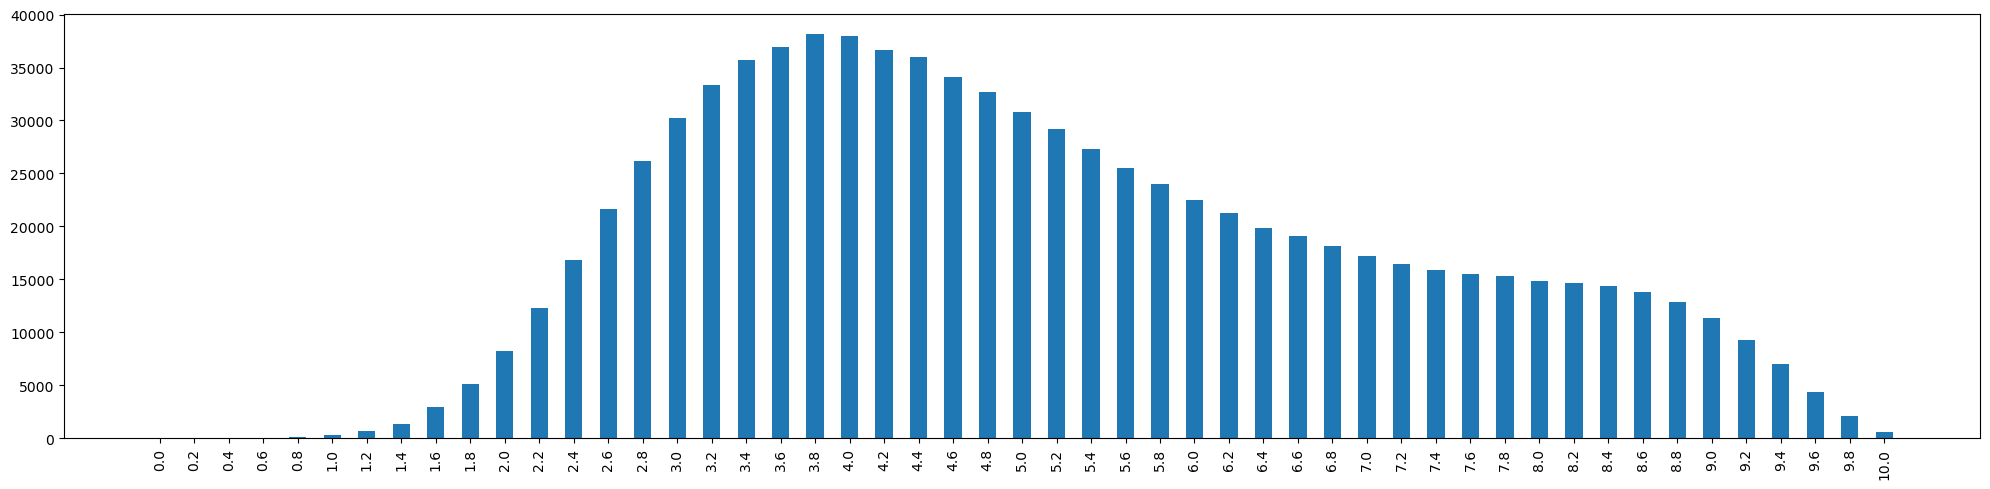


Mean 5.157686401128404


In [66]:
subject_point_spectrum("ngoai_ngu")

Phổ điểm khối A1


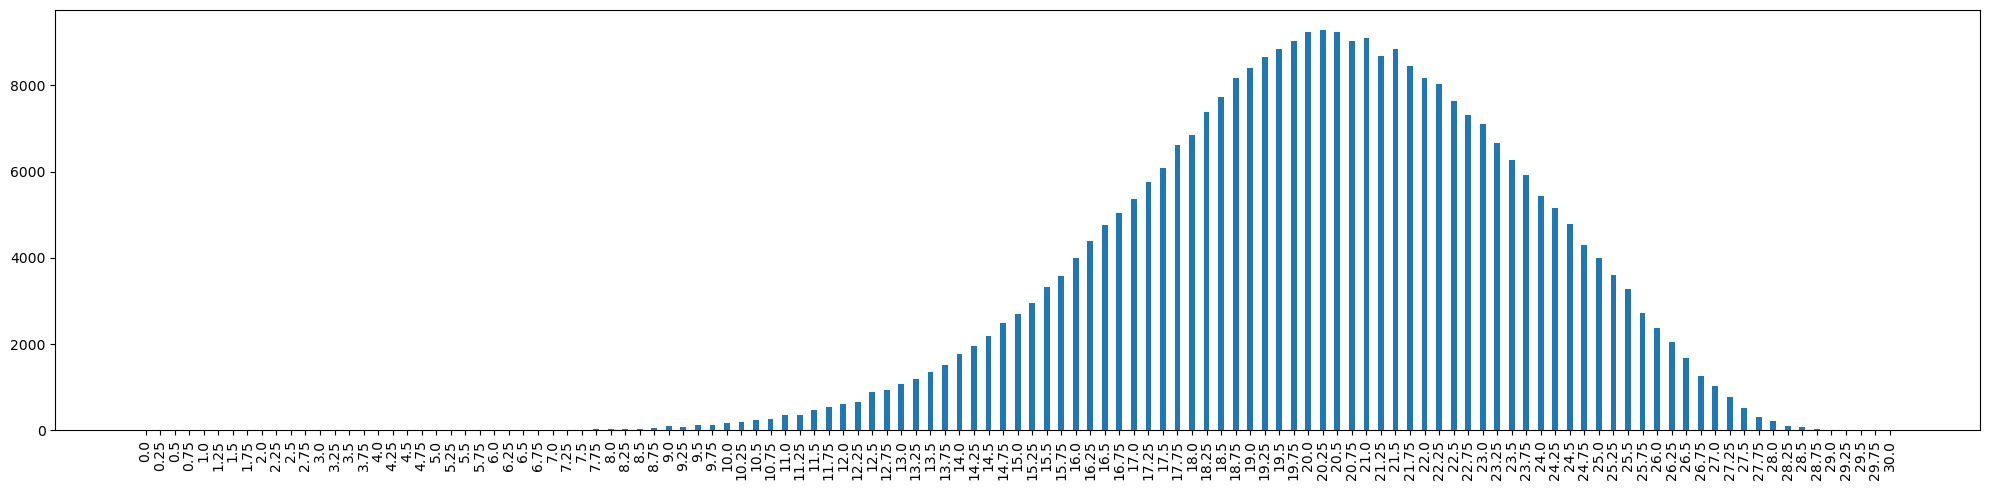


Mean 20.290872906549115


In [67]:
multi_subject_point_spectrum("A1")

Phổ điểm trung bình 


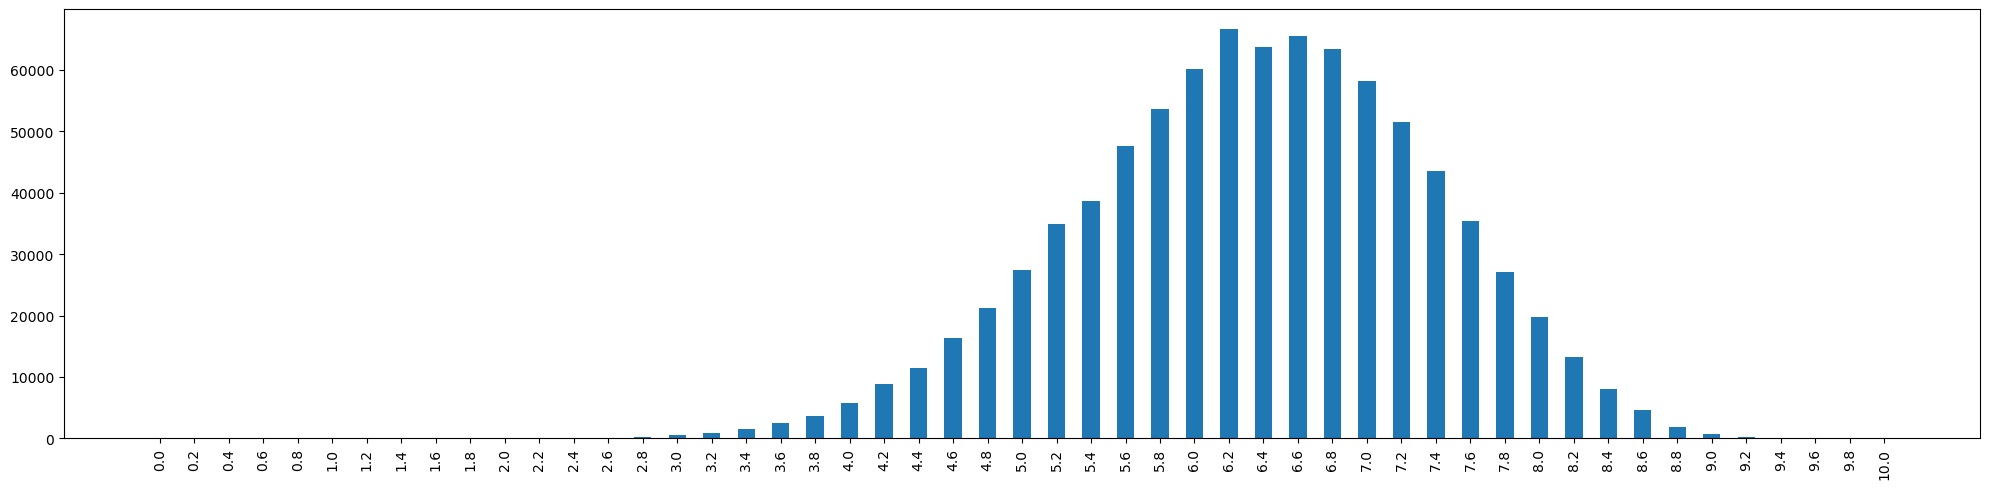


Mean 6.441845394471253


In [68]:
avarage_spectrum()